In [ ]:
## get initial set of labels from karma3

In [2]:
import pandas as pd
from google.cloud import bigquery
import pandas as pd
import glob
client = bigquery.Client()

savepath = f"data"

In [3]:
import requests

response = requests.get("https://lens-api.k3l.io/profile_count?strategy=creator")
count = response.json()['count']

response = requests.get(f"https://lens-api.k3l.io/profile_scores?strategy=creator&limit={count}")
karma_data = response.json()
karma_data = pd.DataFrame(karma_data)
karma_data.to_csv('data/karma_data.csv')
del response
karma_data.head()

,score,rank,handle,followersCount,id
0,0.064284,1,stani.lens,57607,5
1,0.059850,2,bradorbradley.lens,33082,36
2,0.059520,3,christina.lens,28154,142
3,0.055198,4,blackdave.lens,819,36284
4,0.054165,5,chriscomrie.lens,4917,73557


In [4]:
karma_data.shape

(100004, 5)

In [5]:
## get bigquery data

In [13]:


def dispatcher_data_query():
    return """
SELECT
  profile_id,
  profile_dispatcher_address,
  block_timestamp AS dispatcher_setup_timestamp
FROM
  `lens-public-data.polygon.public_profile_dispatcher`
"""




# Perform a query.
QUERY = dispatcher_data_query()
query_job = client.query(QUERY)  # API request
# rows = query_job.result()  # Waits for query to finish
df = query_job.to_dataframe()
df.to_csv(f'{savepath}/dispatcher_data')
df.shape

(82988, 3)

In [11]:

def aggregated_stats_query():
    return f"""
SELECT
  profile_id,
  total_posts,
  total_comments,
  total_mirrors,
  total_collects,
  datastream_metadata.source_timestamp
FROM
  `lens-public-data.polygon.public_profile_stats`
"""

# Perform a query.
QUERY = aggregated_stats_query()
query_job = client.query(QUERY)  # API request
# rows = query_job.result()  # Waits for query to finish
df = query_job.to_dataframe()
df.to_csv(f'{savepath}/aggregated_stats')
df.shape

(116483, 6)

In [12]:
def ens_address_query():
    return f"""
SELECT
  DISTINCT address
FROM
  `lens-public-data.polygon.ens_address_reverse_record`
"""

# Perform a query.
QUERY = ens_address_query()
query_job = client.query(QUERY)  # API request
# rows = query_job.result()  # Waits for query to finish
df = query_job.to_dataframe()
df.to_csv(f'{savepath}/ens_address')
df.shape

(47508, 1)

In [19]:
def proof_of_humanity_query():
    return f"""
SELECT
  DISTINCT address
FROM
  `lens-public-data.polygon.proof_of_humanity_address_to_proof_record`
WHERE
  is_registered=true
"""

# Perform a query.
QUERY = proof_of_humanity_query()
query_job = client.query(QUERY)  # API request
# rows = query_job.result()  # Waits for query to finish
df = query_job.to_dataframe()
df.to_csv(f'{savepath}/proof_of_humanity')
df.shape

(855, 1)

In [20]:
def sybil_dot_org_address_verified_twitter_query():
    return f"""
SELECT
  DISTINCT address
FROM
  `lens-public-data.polygon.sybil_dot_org_address_verified_twitter`
"""

# Perform a query.
QUERY = sybil_dot_org_address_verified_twitter_query()
query_job = client.query(QUERY)  # API request
# rows = query_job.result()  # Waits for query to finish
df = query_job.to_dataframe()
df.to_csv(f'{savepath}/sybil_dot_org_address_verified_twitter')
df.shape

(2784, 1)

In [22]:
def worldcoin_human_check_query():
    return f"""
SELECT
  profile_id
FROM
  `lens-public-data.polygon.worldcoin_human_check`
WHERE
  verified=true
"""

# Perform a query.
QUERY = worldcoin_human_check_query()
query_job = client.query(QUERY)  # API request
# rows = query_job.result()  # Waits for query to finish
df = query_job.to_dataframe()
df.to_csv(f'{savepath}/worldcoin_human_check')
df.shape

(54, 1)

In [24]:
def most_used_app_query():
    return f"""
SELECT
  profile_id,
  ARRAY_AGG( STRUCT(app_id,
      total_posts)
  ORDER BY
    total_posts DESC
  LIMIT
    1 )[
OFFSET
  (0)].app_id AS app_id_highest_posts,
  ARRAY_AGG( STRUCT(app_id,
      total_posts)
  ORDER BY
    total_comments DESC
  LIMIT
    1 )[
OFFSET
  (0)].app_id AS app_id_highest_comments,
FROM
  `lens-public-data.polygon.public_app_profile_stats`
GROUP BY
  profile_id
"""

# Perform a query.
QUERY = most_used_app_query()
query_job = client.query(QUERY)  # API request
# rows = query_job.result()  # Waits for query to finish
df = query_job.to_dataframe()
df.to_csv(f'{savepath}/most_used_app')
df.shape

(94732, 3)

In [2]:
import numpy as np
def q90(x):
    return x.quantile(0.9)
def q10(x):
    return x.quantile(0.1)
def q25(x):
    return x.quantile(0.25)
def q75(x):
    return x.quantile(0.75)


In [ ]:
def getlags(df, lags=-1, by='profile_id'):
    df = df.sort_values(by=['profile_id','block_timestamp'],ascending=[True,False])
    shifted = df.groupby("profile_id").shift(lags)
    df1 = df.join(shifted.rename(columns=lambda x: x+"_lag"))
    df1['diff'] = (df1['block_timestamp'] - df1['block_timestamp_lag']).dt.total_seconds()
    df1 = df1.groupby('profile_id').agg({"diff": [np.mean, np.median,q10,q25,q75,q90,'max','min']})
    df1.columns = [f'{i}_{lags[1:]}' for i in df1.columns]
    return df1

In [3]:
def like_data_insights_query():
    return f"""
SELECT
actioned_by_profile_id as profile_id, action_at as block_timestamp
FROM
  `lens-public-data.polygon.public_publication_reaction_records`
"""

# Perform a query.
QUERY = like_data_insights_query()
query_job = client.query(QUERY)  # API request
# rows = query_job.result()  # Waits for query to finish
df = query_job.to_dataframe()
print('running')
by = 'profile_id'
df1 = getlags(df, lags=-1, by)
df2 = getlags(df, lags=-10, by)
df3 = getlags(df, lags=-20, by)
df1 = df1.join(df2,on=by).join(df3,on=by)

df1.to_csv(f'{savepath}/like_data_insights')
df1.shape

running


(84111, 8)

In [7]:
def post_data_insights_query():
    return f"""
SELECT
  profile_id,
  block_timestamp
FROM
  `lens-public-data.polygon.public_profile_post`
WHERE
  s3_metadata_location IS NOT NULL
  AND has_error IS FALSE
  AND is_metadata_processed IS TRUE
  AND is_related_to_post IS NULL
  AND is_related_to_comment IS null
"""

# Perform a query.
QUERY = post_data_insights_query()
query_job = client.query(QUERY)  # API request
# rows = query_job.result()  # Waits for query to finish
df = query_job.to_dataframe()
print('running')
by = 'profile_id'
df1 = getlags(df, lags=-1, by)
df2 = getlags(df, lags=-10, by)
df3 = getlags(df, lags=-20, by)
df1 = df1.join(df2,on=by).join(df3,on=by)

df1.to_csv(f'{savepath}/post_data_insights')
df1.shape

running


(88645, 8)

In [8]:
def mirror_data_insights_query():
    return f"""
SELECT
  profile_id,
  block_timestamp
FROM
  `lens-public-data.polygon.public_profile_post`
WHERE
  s3_metadata_location IS NOT NULL
  AND has_error IS FALSE
  AND is_metadata_processed IS TRUE
  AND (is_related_to_post IS NOT NULL
    OR is_related_to_comment IS NOT NULL)
"""

# Perform a query.
QUERY = mirror_data_insights_query()
query_job = client.query(QUERY)  # API request
# rows = query_job.result()  # Waits for query to finish
df = query_job.to_dataframe()
print('running')
by = 'profile_id'
df1 = getlags(df, lags=-1, by)
df2 = getlags(df, lags=-10, by)
df3 = getlags(df, lags=-20, by)
df1 = df1.join(df2,on=by).join(df3,on=by)

df1.to_csv(f'{savepath}/mirror_data_insights')
df1.shape

running


(74423, 8)

In [11]:
def comment_data_insights_query():
    return f"""
SELECT
  comment_by_profile_id AS profile_id,
  block_timestamp
FROM
  `lens-public-data.polygon.public_post_comment`
WHERE
  s3_metadata_location IS NOT NULL
  AND has_error IS FALSE
  AND is_metadata_processed IS true
"""

# Perform a query.
QUERY = comment_data_insights_query()
query_job = client.query(QUERY)  # API request
# rows = query_job.result()  # Waits for query to finish
df = query_job.to_dataframe()
print('running')
by = 'profile_id'
df1 = getlags(df, lags=-1, by)
df2 = getlags(df, lags=-10, by)
df3 = getlags(df, lags=-20, by)
df1 = df1.join(df2,on=by).join(df3,on=by)

df1.to_csv(f'{savepath}/comment_data_insights')
df1.shape

running


(72763, 8)

In [12]:
def collect_data_insights_query():
    return f"""
SELECT
  collected_by AS address,
  block_timestamp
FROM
  `lens-public-data.polygon.public_publication_collect_module_collected_records`
"""

# Perform a query.
QUERY = collect_data_insights_query()
query_job = client.query(QUERY)  # API request
# rows = query_job.result()  # Waits for query to finish
df = query_job.to_dataframe()
print('running')
by = 'address'
df1 = getlags(df, lags=-1, by)
df2 = getlags(df, lags=-10, by)
df3 = getlags(df, lags=-20, by)
df1 = df1.join(df2,on=by).join(df3,on=by)

df1.to_csv(f'{savepath}/collect_data_insights')
df1.shape

running


(226908, 8)

In [14]:
def paid_collect_data_insights_query():
    return f"""
WITH
  paid_pubs AS (
  SELECT
    publication_id
  FROM
    `lens-public-data.polygon.public_publication_collect_module_details`
  WHERE
    amount IS NOT NULL )
SELECT
  collected_by AS address,
  block_timestamp
FROM
  `lens-public-data.polygon.public_publication_collect_module_collected_records`
WHERE
  publication_id IN (
  SELECT
    publication_id
  FROM
    paid_pubs)
"""

# Perform a query.
QUERY = paid_collect_data_insights_query()
query_job = client.query(QUERY)  # API request
# rows = query_job.result()  # Waits for query to finish
df = query_job.to_dataframe()
print('running')
by = 'address'
df1 = getlags(df, lags=-1, by)
df2 = getlags(df, lags=-10, by)
df3 = getlags(df, lags=-20, by)
df1 = df1.join(df2,on=by).join(df3,on=by)

df1.to_csv(f'{savepath}/paid_collect_data_insights')
df1.shape

running


(47881, 8)

In [97]:
def address_query():
    return f"""
SELECT
profile_id,
owned_by as address,
is_default,
metadata_block_timestamp,
block_timestamp
FROM
  `lens-public-data.polygon.public_profile`
"""

# Perform a query.
QUERY = address_query()
query_job = client.query(QUERY)  # API request
# rows = query_job.result()  # Waits for query to finish
df = query_job.to_dataframe()

df.to_csv(f'{savepath}/address')
df.shape

(116487, 5)

# read data and make a csv

In [3]:
files = glob.glob(f'{savepath}/*')

In [4]:
files

['data/dispatcher_data',
 'data/post_data_insights',
 'data/collect_data_insights',
 'data/comment_data_insights',
 'data/like_data_insights',
 'data/ens_address',
 'data/mirror_data_insights',
 'data/most_used_app',
 'data/karma_data.csv',
 'data/sybil_dot_org_address_verified_twitter',
 'data/proof_of_humanity',
 'data/address',
 'data/worldcoin_human_check',
 'data/aggregated_stats',
 'data/paid_collect_data_insights']

In [5]:
labels = pd.read_csv(f'{savepath}/karma_data.csv',index_col=0)


In [6]:
address = pd.read_csv(f'{savepath}/address',index_col=0)
address = address.drop({'block_timestamp'},axis=1)#.join( ((pd.to_datetime('2023-04-15',utc=True) - pd.to_datetime(address['block_timestamp'])).dt.total_seconds()/60/24).round(0))
address = address.drop({'metadata_block_timestamp'},axis=1)#.join( ((pd.to_datetime('2023-04-15',utc=True) - pd.to_datetime(address['metadata_block_timestamp'])).dt.total_seconds()/60/24).round(0))

address = address.rename({'block_timestamp':'days_since_profile_created', 'metadata_block_timestamp':'days_since_metadata_changed'},axis=1)



In [7]:
dispatcher = pd.read_csv(f'{savepath}/dispatcher_data',index_col=0)
dispatcher = dispatcher.drop(['profile_dispatcher_address','dispatcher_setup_timestamp'],axis=1).join(pd.get_dummies(dispatcher['profile_dispatcher_address'])).join( ((pd.to_datetime('2023-04-15',utc=True) - pd.to_datetime(dispatcher['dispatcher_setup_timestamp'])).dt.total_seconds()/60/24).round(0))
dispatcher = dispatcher.rename({'dispatcher_setup_timestamp':'days_since_dispatcher_changed'},axis=1)

profile_data = pd.merge(dispatcher,address, on='profile_id', how='outer')


worldcoin_human = pd.read_csv(f'{savepath}/worldcoin_human_check',index_col=0)
worldcoin_human['worldcoin_human']=True
profile_data = pd.merge(profile_data,worldcoin_human, on='profile_id', how='outer')

aggregated_stats = pd.read_csv(f'{savepath}/aggregated_stats',index_col=0)
profile_data = pd.merge(profile_data,aggregated_stats, on='profile_id', how='outer')



In [8]:
def read_insight_data(profile_data, name,group_col='profile_id'):
    profile_data.copy()
    df = pd.read_csv(f'{savepath}/{name}',index_col=0,skiprows=[0,2])
    df.columns = [f'{i}_{name}' for i in df.columns]
    profile_data = pd.merge(profile_data,df, left_on=group_col,right_index=True, how='outer')
    return profile_data

profile_data = read_insight_data(profile_data, name='post_data_insights')

profile_data = read_insight_data(profile_data, name='comment_data_insights')

profile_data = read_insight_data(profile_data, name='mirror_data_insights')

profile_data = read_insight_data(profile_data, name='like_data_insights')


In [9]:
most_used_app = pd.read_csv(f'{savepath}/most_used_app',index_col=0)
most_used_app = most_used_app.join(pd.get_dummies(most_used_app[['app_id_highest_posts','app_id_highest_comments']])).drop(['app_id_highest_posts','app_id_highest_comments'],axis=1)
profile_data = pd.merge(profile_data,most_used_app, on='profile_id', how='outer')


In [10]:
ens_address = pd.read_csv(f'{savepath}/ens_address',index_col=0)
ens_address['ens']=True

proof_of_humanity = pd.read_csv(f'{savepath}/proof_of_humanity',index_col=0)
proof_of_humanity['proof_of_humanity']=True

sybil_dot_org_address_verified_twitter = pd.read_csv(f'{savepath}/sybil_dot_org_address_verified_twitter',index_col=0)
sybil_dot_org_address_verified_twitter['sybil_dot_org_address_verified_twitter']=True

address_data = pd.merge(ens_address,proof_of_humanity, on='address',how='outer')
address_data = pd.merge(address_data,sybil_dot_org_address_verified_twitter, on='address',how='outer')

address_data = read_insight_data(address_data, name='collect_data_insights',group_col='address')

address_data = read_insight_data(address_data, name='paid_collect_data_insights',group_col='address')



In [11]:
data = profile_data.merge(address_data,on='address',how='outer').drop('address',axis=1)

In [12]:
data.shape

(265680, 214)

In [13]:
def intify(x):
    return int(x,16)



In [14]:
data = data.dropna(subset=['profile_id'])
data['id'] = data['profile_id'].apply(intify)
data = data.set_index('profile_id')
data.shape

(116488, 214)

In [15]:
data.head()

,0x112b57A293d99b79Fe360Af042bb3bfFc824Ab3a,0x25418Bcf53dAe1167cD5d0cad34Eec31C0C37E41,0x3530c7CAc2E47F27bA82a5d0D3671181171292DB,0x45F71328a415129CB25e3917e70f5BCA346C6151,0x46fAf146C4683663667af868dFc2F98ADc27fBd6,0x57B7bf6f792a6181Ec5aFB88cE7bcE330a9d1b67,0x62D0e168e35f87a1dB804C2b2daf63AE4D195cD1,0x6bC45934A408f7151093479bf59933cD3B75701d,0x761010EFc8826fFdcb8Ad005BD935698ed38DfE7,0x76D4fFdA8c66864FA07f0a285B8E01E11b4Bb7b3,...,min_collect_data_insights,mean_paid_collect_data_insights,median_paid_collect_data_insights,q10_paid_collect_data_insights,q25_paid_collect_data_insights,q75_paid_collect_data_insights,q90_paid_collect_data_insights,max_paid_collect_data_insights,min_paid_collect_data_insights,id
profile_id,,,,,,,,,,,,,,,,,,,,,
0xacae,False,False,False,True,False,False,False,False,False,False,...,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44206
0xf803,False,False,False,False,True,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63491
0xa738,False,False,False,False,False,False,False,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42808
0x8d06,False,False,False,True,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36102
0xe56e,False,False,False,True,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58734


In [16]:
data = data.merge(labels,on='id',how='inner')
data = data.fillna(-1)

In [47]:
bad = data.dropna(subset=['rank','total_mirrors']).query('total_mirrors>100').sort_values(by='rank').tail(500).drop(labels.columns,axis=1)
good = data.sort_values(by='rank').head(500).drop(labels.columns,axis=1)
bad['label'] = 0
good['label'] = 1

training_data = pd.concat([bad,good])
validation_data = data.drop(training_data.index).drop(labels.columns,axis=1)


/var/folders/yt/6t964r9x3q51ryt05dfj1b3m0000gn/T/ipykernel_59536/523553640.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  good['label'] = 1


In [48]:
def get_dtypes(data):
    data[data.dtypes[data.dtypes=='object'].index] = data[data.dtypes[data.dtypes=='object'].index].astype('int')
    data[data.dtypes[data.dtypes=='bool'].index] = data[data.dtypes[data.dtypes=='bool'].index].astype('int')

    return data


In [49]:
training_data = get_dtypes(training_data)
validation_data = get_dtypes(validation_data)

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(training_data.drop('label',axis=1), training_data['label'], test_size=0.33, random_state=42)

In [52]:
training_data.dtypes.value_counts()

int64      160
float64     54
Name: count, dtype: int64

In [53]:
from pytorch_tabnet.tab_model import TabNetClassifier


In [58]:
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)

In [59]:
max_epochs = 1000


In [82]:
from sklearn.preprocessing import QuantileTransformer

In [83]:
mc = QuantileTransformer()

In [84]:
unsupervised_model.fit(
     X_train=mc.fit_transform(validation_data.values),
     eval_set=[mc.transform(training_data.drop('label',axis=1).values)],
    
       

    max_epochs=max_epochs , patience=10,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
) 

epoch 0  | loss: 8.86875 | val_0_unsup_loss_numpy: 18190180352.0|  0:00:08s
epoch 5  | loss: 0.24432 | val_0_unsup_loss_numpy: 1306392064.0|  0:00:51s
epoch 10 | loss: 0.17997 | val_0_unsup_loss_numpy: 436809888.0|  0:01:37s
epoch 15 | loss: 0.15985 | val_0_unsup_loss_numpy: 441251488.0|  0:02:29s
epoch 20 | loss: 0.14498 | val_0_unsup_loss_numpy: 727568896.0|  0:03:22s
epoch 25 | loss: 0.13453 | val_0_unsup_loss_numpy: 545215744.0|  0:04:14s

Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_unsup_loss_numpy = 312344704.0


/Users/kimmo/anaconda3/envs/lens-bot-or-not/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [63]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-3),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax', # This will be overwritten if using pretrain model
                       verbose=5,
                      )

/Users/kimmo/anaconda3/envs/lens-bot-or-not/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [64]:
clf.fit(
    X_train=mc.fit_transform(X_train.values), y_train=y_train.values,
    eval_set=[(mc.transform(X_train.values), y_train.values), (mc.transform(X_test.values), y_test.values)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss'],
    max_epochs=max_epochs , patience=5,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=unsupervised_model,
    
) 

/Users/kimmo/anaconda3/envs/lens-bot-or-not/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/Users/kimmo/anaconda3/envs/lens-bot-or-not/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.86277 | train_logloss: 0.72051 | valid_logloss: 0.7812  |  0:00:00s
epoch 5  | loss: 0.87292 | train_logloss: 0.72321 | valid_logloss: 0.74819 |  0:00:00s

Early stopping occurred at epoch 8 with best_epoch = 3 and best_valid_logloss = 0.74399


/Users/kimmo/anaconda3/envs/lens-bot-or-not/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [65]:
from sklearn.metrics import roc_auc_score


In [66]:
preds = clf.predict_proba(mc.transform(validation_data.values))
# test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(mc.transform(X_test.values))
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_test)

print(f"BEST VALID SCORE : {clf.best_cost}")
#print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE : 0.7439870819996505


In [67]:
pd.Series(preds.argmax(1)).value_counts()

0    69670
1    29334
Name: count, dtype: int64

<Axes: xlabel='rank', ylabel='label'>

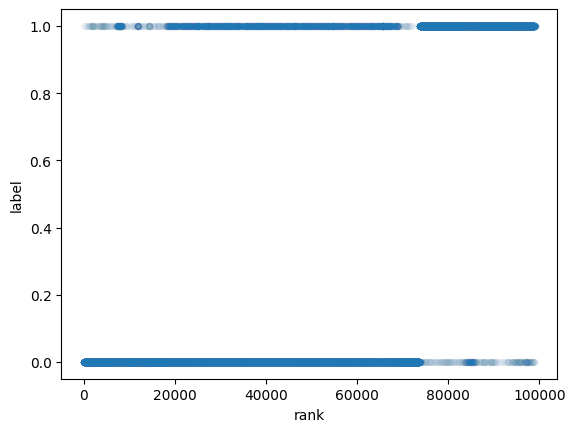

In [78]:
pd.Series(preds.argmax(1),name='label').reset_index().join(labels).plot.scatter(x='rank',y='label',alpha=0.01)

In [80]:
pd.Series(preds.argmax(1),name='label').reset_index().join(labels).head()

,index,label,score,rank,handle,followersCount,id
0,0,1,0.064284,1,stani.lens,57607,5
1,1,0,0.059850,2,bradorbradley.lens,33082,36
2,2,0,0.059520,3,christina.lens,28154,142
3,3,0,0.055198,4,blackdave.lens,819,36284
4,4,1,0.054165,5,chriscomrie.lens,4917,73557
